# Phân tích và phân nhóm các cửa hàng Walmart theo đặc điểm doanh số và hành vi bán hàng

## I. KHAI BÁO THƯ VIỆN ĐỂ THỰC HIỆN PHÂN TÍCH

In [106]:
# Khai báo thư viện
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importando a biblioteca para carregar arquivos do drive
#from google.colab import drive

# Khai báo thư viện để phân cụm
from sklearn.cluster import KMeans

# Khai báo thư viện để chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler

# Khai báo thư viện để phân tích xu hướng, phân tích theo mùa và phần dư
from statsmodels.tsa.seasonal import seasonal_decompose

# Khai báo thư viện để trực quan hóa dữ liệu
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

## II. TIỀN XỬ LÝ DỮ LIỆU

### 1. Kiểm tra dữ liệu

#### 1.1. Nhập dữ liệu

In [32]:
data = pd.read_csv("stores.csv")
data1 = pd.read_csv("features.csv")
data2 = pd.read_csv("train.csv")

#### 1.2. Kiểm tra thông tin dữ liệu

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [74]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Fuel_Price    8190 non-null   float64       
 3   CPI           7605 non-null   float64       
 4   Unemployment  7605 non-null   float64       
 5   IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 328.0 KB


In [75]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday2    421570 non-null  bool          
 5   Year          421570 non-null  int32         
 6   Month         421570 non-null  int32         
 7   Weeks         421570 non-null  UInt32        
dtypes: UInt32(1), bool(1), datetime64[ns](1), float64(1), int32(2), int64(2)
memory usage: 18.5 MB


#### 1.3. Kiểm tra dữ liệu bị thiếu ở các bảng

In [70]:
 data.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [71]:
 data1.isnull().sum()

Store             0
Date              0
Fuel_Price        0
CPI             585
Unemployment    585
IsHoliday         0
dtype: int64

In [72]:
 data2.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday2      0
Year            0
Month           0
Weeks           0
dtype: int64

#### 1.4. Điều chỉnh dữ liệu

In [33]:
data1 = data1.drop(['Temperature', 'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1)

In [79]:
# Chuyển ngày từ dữ liệu chuối thành dữ liệu ngày tháng
data1['Date'] =  pd.to_datetime(data1['Date'])
# Kiểm tra lại thông tin dữ liệu
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Fuel_Price    8190 non-null   float64       
 3   CPI           7605 non-null   float64       
 4   Unemployment  7605 non-null   float64       
 5   IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 328.0 KB


In [80]:
# Tương tự với Data1, chuyển dữ liệu của Date
data2['Date'] = pd.to_datetime(data2['Date'])
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday2    421570 non-null  bool          
 5   Year          421570 non-null  int32         
 6   Month         421570 non-null  int32         
 7   Weeks         421570 non-null  UInt32        
dtypes: UInt32(1), bool(1), datetime64[ns](1), float64(1), int32(2), int64(2)
memory usage: 18.5 MB


In [81]:
data2['Year'] = data2['Date'].dt.year
data2['Month'] = data2['Date'].dt.month
data2['Weeks'] = data2['Date'].dt.isocalendar().week

data = data.rename(columns={'IsHoliday':'IsHoliday0'})
data2 = data2.rename(columns={'IsHoliday':'IsHoliday2'})


### 2. Hợp nhất các cột giữa các bảng

In [82]:
# Gộp cách cột trong các bảng lại với nhau
model1 = pd.merge(data2, data, on='Store', how='left')
df_model1 = pd.merge(model1, data1, on=['Store', 'Date'], how='left')

df_model1.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday2,Year,Month,Weeks,Type,Size,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,False,2010,2,5,A,151315,2.572,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,2010,2,6,A,151315,2.548,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,2010,2,7,A,151315,2.514,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,2010,2,8,A,151315,2.561,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,2010,3,9,A,151315,2.625,211.350143,8.106,False


In [83]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday2    421570 non-null  bool          
 5   Year          421570 non-null  int32         
 6   Month         421570 non-null  int32         
 7   Weeks         421570 non-null  UInt32        
 8   Type          421570 non-null  object        
 9   Size          421570 non-null  int64         
 10  Fuel_Price    421570 non-null  float64       
 11  CPI           421570 non-null  float64       
 12  Unemployment  421570 non-null  float64       
 13  IsHoliday     421570 non-null  bool          
dtypes: UInt32(1), bool(2), datetime64[ns](1), float64(4), int32(2), int6

In [84]:
# Kiểm tra IsHoliday và IsHoliday2 ở hai bảng có trùng khớp hay không
print(df_model1['IsHoliday'].value_counts().sort_values(ascending=False))
holiday0 = df_model1[df_model1['IsHoliday']==1]
r1 = holiday0['Date'].unique()
print(r1)
print('')

print(df_model1['IsHoliday2'].value_counts().sort_values(ascending=False))
holiday2 = df_model1[df_model1['IsHoliday2']==1]
r2 = holiday2['Date'].unique()
print(r2)

IsHoliday
False    391909
True      29661
Name: count, dtype: int64
<DatetimeArray>
['2010-02-12 00:00:00', '2010-09-10 00:00:00', '2010-11-26 00:00:00',
 '2010-12-31 00:00:00', '2011-02-11 00:00:00', '2011-09-09 00:00:00',
 '2011-11-25 00:00:00', '2011-12-30 00:00:00', '2012-02-10 00:00:00',
 '2012-09-07 00:00:00']
Length: 10, dtype: datetime64[ns]

IsHoliday2
False    391909
True      29661
Name: count, dtype: int64
<DatetimeArray>
['2010-02-12 00:00:00', '2010-09-10 00:00:00', '2010-11-26 00:00:00',
 '2010-12-31 00:00:00', '2011-02-11 00:00:00', '2011-09-09 00:00:00',
 '2011-11-25 00:00:00', '2011-12-30 00:00:00', '2012-02-10 00:00:00',
 '2012-09-07 00:00:00']
Length: 10, dtype: datetime64[ns]


In [94]:
print(df_model1.columns.tolist())

['Store', 'Dept', 'Date', 'Weekly_Sales', 'Year', 'Month', 'Weeks', 'Type', 'Size', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']


In [90]:
#df_model1 = df_model1.drop(['IsHoliday2'], axis =1)

### 3. Kiểm tra dữ liệu sau khi gộp

#### 3.1. Kiểm tra giá trị bị thiếu (Missing Value)

In [91]:
 df_model1.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
Year            0
Month           0
Weeks           0
Type            0
Size            0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

#### 3.2. Kiểm tra kiểu dữ liệu

In [93]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   Year          421570 non-null  int32         
 5   Month         421570 non-null  int32         
 6   Weeks         421570 non-null  UInt32        
 7   Type          421570 non-null  object        
 8   Size          421570 non-null  int64         
 9   Fuel_Price    421570 non-null  float64       
 10  CPI           421570 non-null  float64       
 11  Unemployment  421570 non-null  float64       
 12  IsHoliday     421570 non-null  bool          
dtypes: UInt32(1), bool(1), datetime64[ns](1), float64(4), int32(2), int64(3), object(1)
memory usage: 34.6+ MB


Dự liệu hoàn toàn đầy đủ và không có dấu hiệu thiếu dữ liệu (Missing Value)

### 4. Chuẩn hóa dữ liệu

In [98]:
print(df_model1.head())

   Store  Dept       Date  Weekly_Sales  Year  Month  Weeks Type    Size  \
0      1     1 2010-02-05      24924.50  2010      2      5    A  151315   
1      1     1 2010-02-12      46039.49  2010      2      6    A  151315   
2      1     1 2010-02-19      41595.55  2010      2      7    A  151315   
3      1     1 2010-02-26      19403.54  2010      2      8    A  151315   
4      1     1 2010-03-05      21827.90  2010      3      9    A  151315   

   Fuel_Price         CPI  Unemployment  IsHoliday  
0       2.572  211.096358         8.106      False  
1       2.548  211.242170         8.106       True  
2       2.514  211.289143         8.106      False  
3       2.561  211.319643         8.106      False  
4       2.625  211.350143         8.106      False  


In [148]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Sao chép dữ liệu gốc để tránh ghi đè
df_norm = df_model1.copy()

# Chọn các cột số để chuẩn hóa
numeric_cols = ['Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']

# Chuẩn hóa theo Z-score (StandardScaler)
scaler = StandardScaler()
df_norm[numeric_cols] = scaler.fit_transform(df_norm[numeric_cols])

# Nếu muốn chuẩn hóa về [0,1] (MinMaxScaler)
# scaler = MinMaxScaler()
# df_norm[numeric_cols] = scaler.fit_transform(df_norm[numeric_cols])

# Mã hóa biến phân loại nếu cần (Type)
df_norm = pd.get_dummies(df_norm, columns=['Type'], drop_first=True)

# Kiểm tra kết quả
print(df_norm.head())

   Store  Dept       Date  Weekly_Sales  Year  Month  Weeks      Size  \
0      1     1 2010-02-05      0.393782  2010      2      5  0.239209   
1      1     1 2010-02-12      1.323501  2010      2      6  0.239209   
2      1     1 2010-02-19      1.127829  2010      2      7  0.239209   
3      1     1 2010-02-26      0.150687  2010      2      8  0.239209   
4      1     1 2010-03-05      0.257435  2010      3      9  0.239209   

   Fuel_Price       CPI  Unemployment  IsHoliday  Type_B  Type_C  
0   -1.720834  1.018774      0.078201      False   False   False  
1   -1.773177  1.022498      0.078201       True   False   False  
2   -1.847330  1.023697      0.078201      False   False   False  
3   -1.744825  1.024476      0.078201      False   False   False  
4   -1.605243  1.025255      0.078201      False   False   False  


## III. PHÂN TÍCH DỮ LIỆU

### 1. Thống kê cơ bản

In [100]:
df_model1.describe()

,Store,Dept,Date,Weekly_Sales,Year,Month,Weeks,Size,Fuel_Price,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.0,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,2010.968591,6.449510,25.826762,136727.915739,3.361027,171.201947,7.960289
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,2010.000000,1.000000,1.0,34875.000000,2.472000,126.064000,3.879000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,2010.000000,4.000000,14.0,93638.000000,2.933000,132.022667,6.891000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,2011.000000,6.000000,26.0,140167.000000,3.452000,182.318780,7.866000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,2012.000000,9.000000,38.0,202505.000000,3.738000,212.416993,8.572000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,2012.000000,12.000000,52.0,219622.000000,4.468000,227.232807,14.313000
std,12.785297,30.492054,NaN,22711.183519,0.796876,3.243217,14.151887,60980.583328,0.458515,39.159276,1.863296


### 2. Biểu đồ xu hướng doanh số theo thời gian


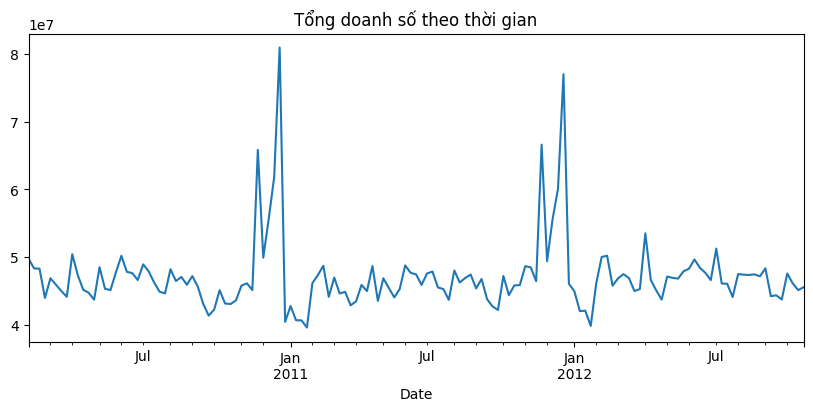

In [101]:
import matplotlib.pyplot as plt
df_model1.groupby('Date')['Weekly_Sales'].sum().plot(figsize=(10,4), title='Tổng doanh số theo thời gian')
plt.show()


### 3. Doanh số theo cửa hàng

<Axes: title={'center': 'Doanh số trung bình theo cửa hàng'}, xlabel='Store'>

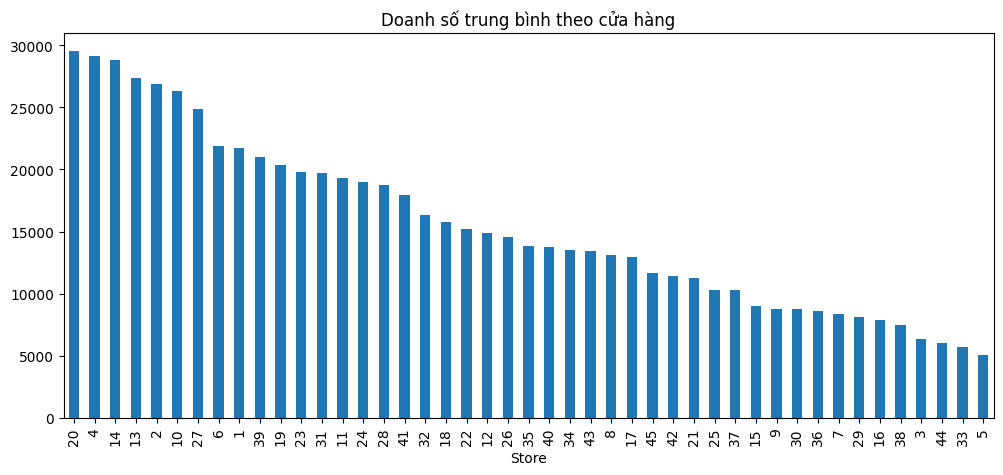

In [102]:
store_sales = df_model1.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)
store_sales.plot(kind='bar', figsize=(12,5), title='Doanh số trung bình theo cửa hàng')

### 4. Mối tương quan giữa các biến

<Axes: >

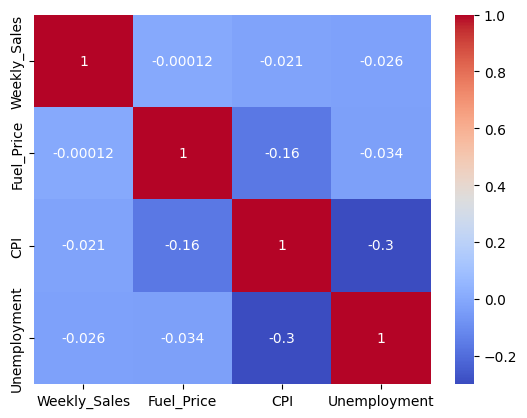

In [107]:
sns.heatmap(df_model1[['Weekly_Sales','Fuel_Price','CPI','Unemployment']].corr(), annot=True, cmap='coolwarm')

## IV. PHƯƠNG PHÁP PHÂN CỤM

### 1. Chuẩn bị dữ liệu cho phân cụm

In [108]:
X = df_model1.groupby('Store')[['Weekly_Sales','Fuel_Price','CPI','Unemployment']].mean()

In [109]:
X_scaled = scaler.fit_transform(X)

### 2. Chọn số cụm tối ưu (Elbow Method)

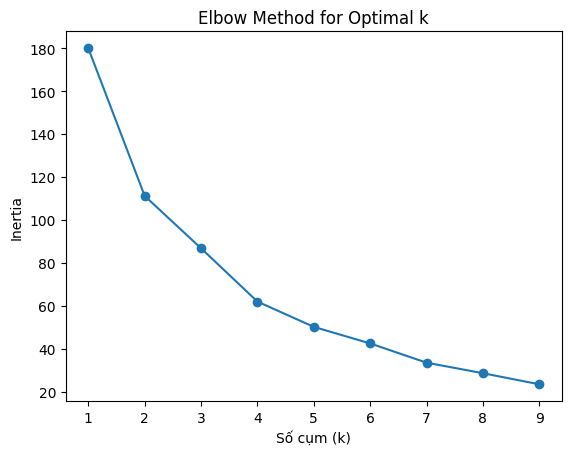

In [111]:
inertia = []
for k in range(1,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1,10), inertia, 'o-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')
plt.show()

### 3. Thực hiện phân cụm K-Means

In [117]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
X['Cluster'] = clusters

## V. PHÂN TÍCH KẾT QUẢ PHÂN CỤM

### 1. Thống kê từng cụm

In [121]:
X.groupby('Cluster').mean()

,Weekly_Sales,Fuel_Price,CPI,Unemployment
Cluster,,,,
0,16370.737515,3.464851,134.774801,8.466574
1,14463.053382,3.251851,210.090842,7.502646


### 2. Trực quan hóa kết quả

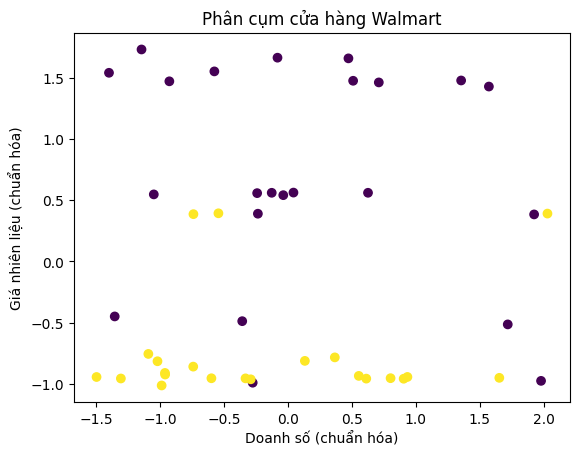

In [122]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=clusters, cmap='viridis')
plt.title('Phân cụm cửa hàng Walmart')
plt.xlabel('Doanh số (chuẩn hóa)')
plt.ylabel('Giá nhiên liệu (chuẩn hóa)')
plt.show()

### 3. Diễn giải ý nghĩa các cụm

## VI. TRỰC QUAN HÓA DỮ LIỆU (MỞ RỘNG)

### 1. Heatmap doanh số trung bình theo cụm:

<Axes: ylabel='Cluster'>

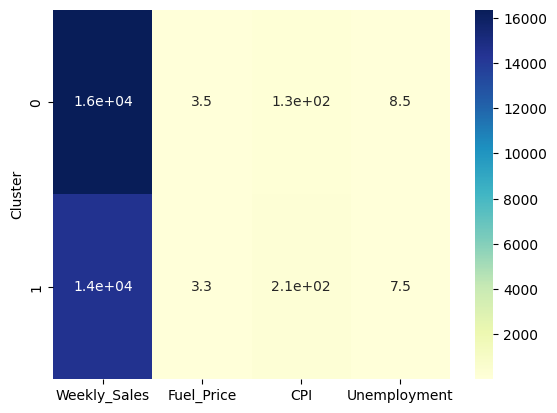

In [123]:
sns.heatmap(X.groupby('Cluster').mean(), annot=True, cmap='YlGnBu')


### 2. Pairplot để xem mối quan hệ giữa các biến trong từng cụm:

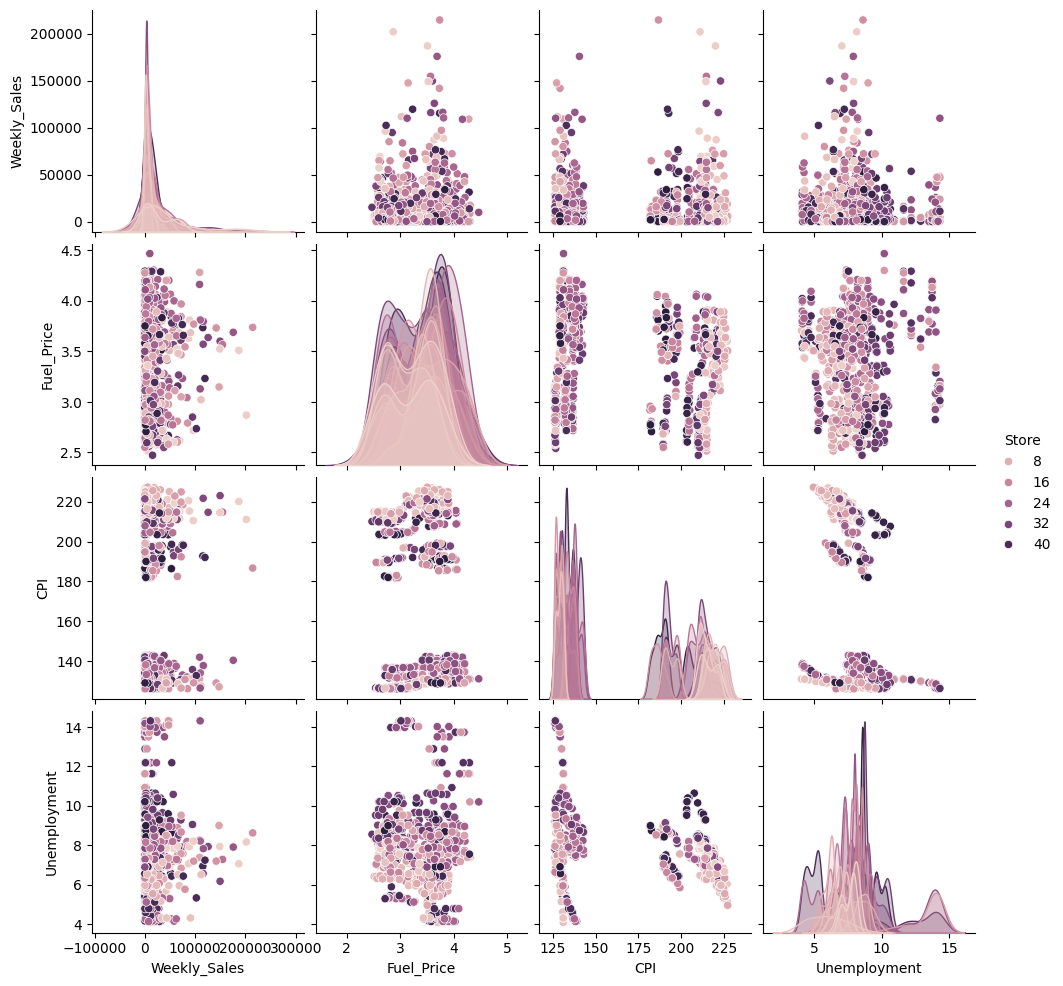

In [128]:
sns.pairplot(df_model1.sample(1000), vars=['Weekly_Sales','Fuel_Price','CPI','Unemployment'], hue='Store')